In [1]:
import scipy.io as sio
from scipy.io import loadmat
import numpy as np
import mat73
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from netCDF4 import Dataset
from scipy.signal import windows
import xarray as xr
from matplotlib.lines import Line2D
from scipy import signal
from scipy.fft import fft, fftshift

In [2]:
# Load .mat file
#mat=sio.loadmat('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/forCristina_202409/data/RAPID/houk-griddedvelo/v_transport_to_WB2_20040329_20181121.mat')
mat=mat73.loadmat('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/Sverdrup/Data/v_transport_to_WB3_20040329_20230214.mat')

In [3]:
#print(mat)
# Extract variables from the .mat file
ac_time=mat['sd'].flatten()#1D array 1*10700
depth=mat['z_west_of_wb2']# 251*45 (45 columns having the exact row values)
ac_trans=mat['t_west_of_wb2'].flatten()#1D array 1*10700
ac_trans_depth=mat['td_west_of_wb2'] #2D 251*10700

# Flatten depth to match ac_trans_depth
depth_flattened = np.mean(depth, axis=1)
# Ensure depth_flattened is correctly shaped
depth_flattened = depth_flattened[:, np.newaxis]  # Shape should now be (251, 1) to align with depth dimension of ac_trans_depth

#print(len(ac_time))
#print(len(ac_trans))
#print(ac_time)

In [4]:
start_date=pd.Timestamp('2004-03-29 12:00:00')#start RAPID data
# Convert months to datetime
try:
    ac_dates = [start_date + pd.Timedelta(day=float(day)) for day in ac_time]
except ValueError as e:
    ac_dates = pd.date_range(start=start_date, periods=len(ac_time), freq='12H')#I have two values/day
    
#print(ac_dates)

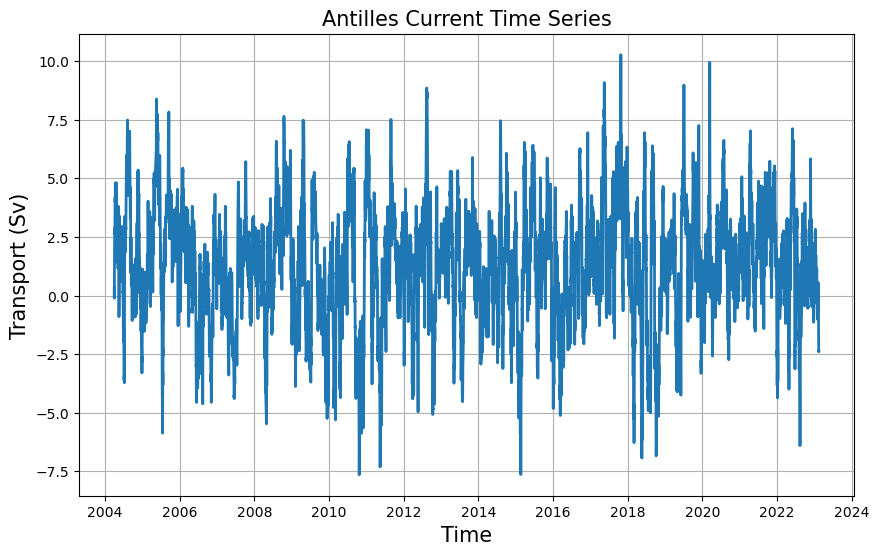

In [5]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(ac_dates,ac_trans/1e6,color='C0',linewidth=2)
plt.xlabel('Time',fontsize=15)
plt.ylabel('Transport (Sv)',fontsize=15)
plt.title('Antilles Current Time Series',fontsize=15)
plt.grid(True)
plt.show()

In [6]:
# Calculate mean and std of AC transport
mean_ac_transport=np.nanmean(ac_trans/1e6)
print(mean_ac_transport)
std_ac_transport=np.nanstd(ac_trans/1e6)
print(std_ac_transport)

1.2565636503051463
2.5125834631403743


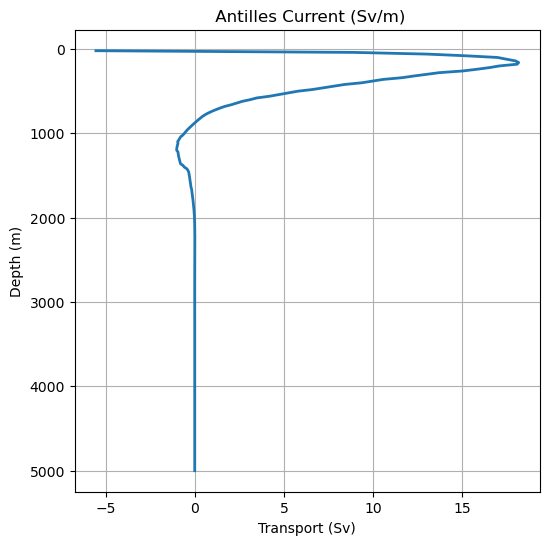

In [7]:
# Extract one column of depth (assuming all columns are identical)
depth_single_column = depth[:, 0]  # Take the first column of depth

# Average ac_trans_depth over time
avg_ac_trans_depth = np.mean(ac_trans_depth, axis=1)  # Averaging across time

# Calculate average AC transport per unit depth (Sv/m)
# Ensure we handle division by zero if there are any zero depth values
depth_nonzero = np.where(depth_single_column != 0, depth_single_column, np.nan)  # Replace zero depths with NaN to avoid division by zero
transport_per_unit_depth = np.divide(avg_ac_trans_depth, depth_nonzero)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(transport_per_unit_depth, depth_single_column, label='Transport per Unit Depth', color='C0',linewidth=2)
plt.gca().invert_yaxis()  # Depth typically increases downward
plt.xlabel('Transport (Sv)')
plt.ylabel('Depth (m)')
plt.title(' Antilles Current (Sv/m)')
plt.grid(True)
plt.show()

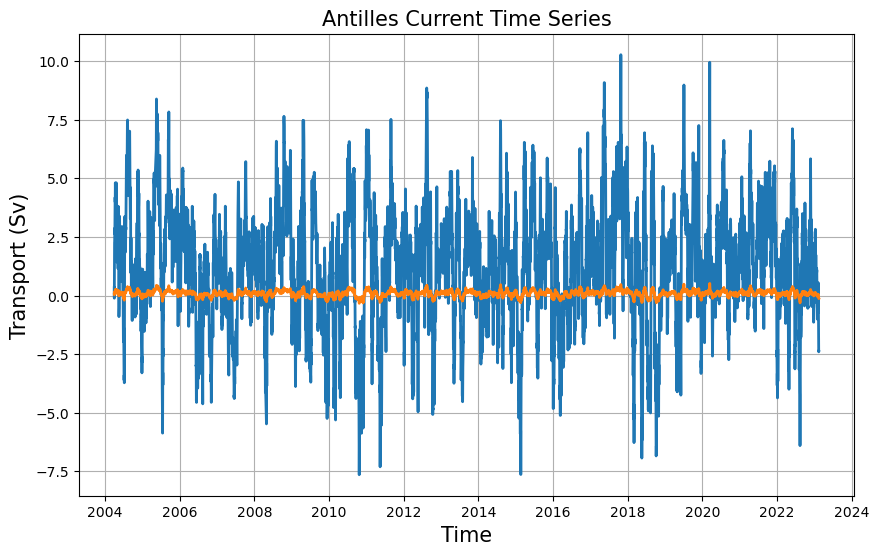

In [8]:
# Determine the indices for depth range 0 to 1100 meters
depth_indices = np.logical_and(depth[:, 0] >= 0, depth[:, 0] <= 1100)

# Extract the transport data for the selected depth range
ac_trans_depth_range = ac_trans_depth[depth_indices, :]

# Average the transport over the selected depth range
integrated_ac_trans = np.sum(ac_trans_depth_range, axis=0)  # Sum across depth for each time point

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(ac_dates,ac_trans/1e6,color='C0',linewidth=2)
plt.plot(ac_dates,integrated_ac_trans/1e6, color='C1',linewidth=2)
#plt.plot(ac_dates, ac_trans_at_depth/1e3, color='C2',linewidth=2)
plt.xlabel('Time',fontsize=15)
plt.ylabel('Transport (Sv)',fontsize=15)
plt.title('Antilles Current Time Series',fontsize=15)
plt.grid(True)
plt.show()


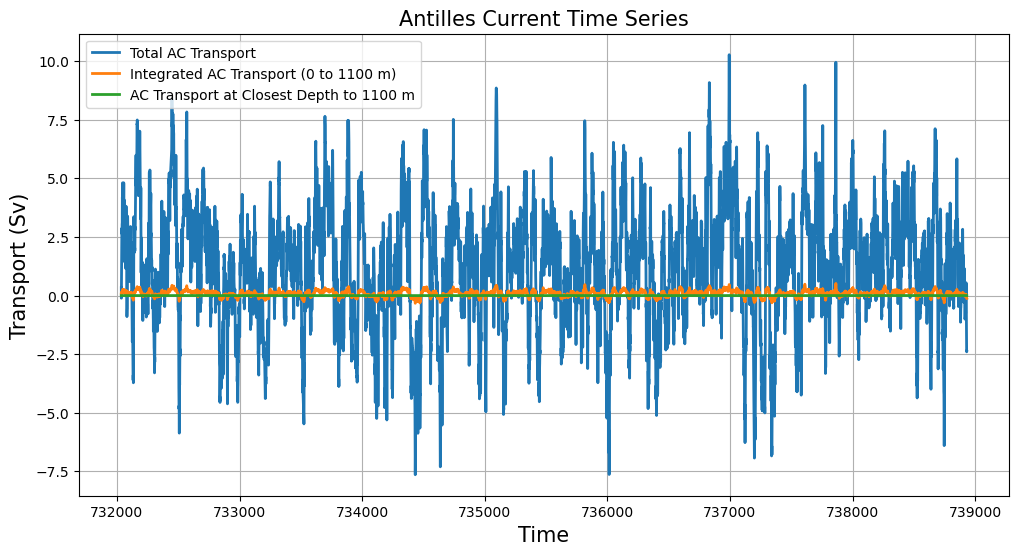

In [9]:
# Determine the indices for depth range 0 to 1100 meters
depth_indices = np.logical_and(depth[:, 0] >= 0, depth[:, 0] <= 1100)

# Extract the transport data for the selected depth range
ac_trans_depth_range = ac_trans_depth[depth_indices, :]

# Average the transport over the selected depth range
integrated_ac_trans = np.nansum(ac_trans_depth_range, axis=0)  # Sum across depth for each time point

# Find the index of the depth closest to 1100 meters
depth_values = depth[:, 0]  # Use the first column of depth values
closest_depth_index = np.abs(depth_values - 1100).argmin()

# Extract the AC transport at the closest depth
ac_trans_at_depth = ac_trans_depth[closest_depth_index, :]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(ac_time, ac_trans / 1e6, color='C0', linewidth=2, label='Total AC Transport')
plt.plot(ac_time, integrated_ac_trans / 1e6, color='C1', linewidth=2, label='Integrated AC Transport (0 to 1100 m)')
plt.plot(ac_time, ac_trans_at_depth / 1e6, color='C2', linewidth=2, label='AC Transport at Closest Depth to 1100 m')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Transport (Sv)', fontsize=15)
plt.title('Antilles Current Time Series', fontsize=15)
plt.legend()
plt.grid(True)
plt.show()


In [10]:
print(ac_trans)
print(integrated_ac_trans)
print(ac_trans_at_depth)

[  333964.80909912  -112340.35164613   322029.29183375 ...
 -2344848.98106675 -2401604.83537875 -2377582.15430456]
[  59931.77698448   31713.90746141   41166.53585075 ... -123075.81214514
 -127844.56458758 -126373.67796611]
[-2055.86927384 -1921.22970521 -1926.26845837 ...  -470.3707546
    45.43608816   143.35339374]


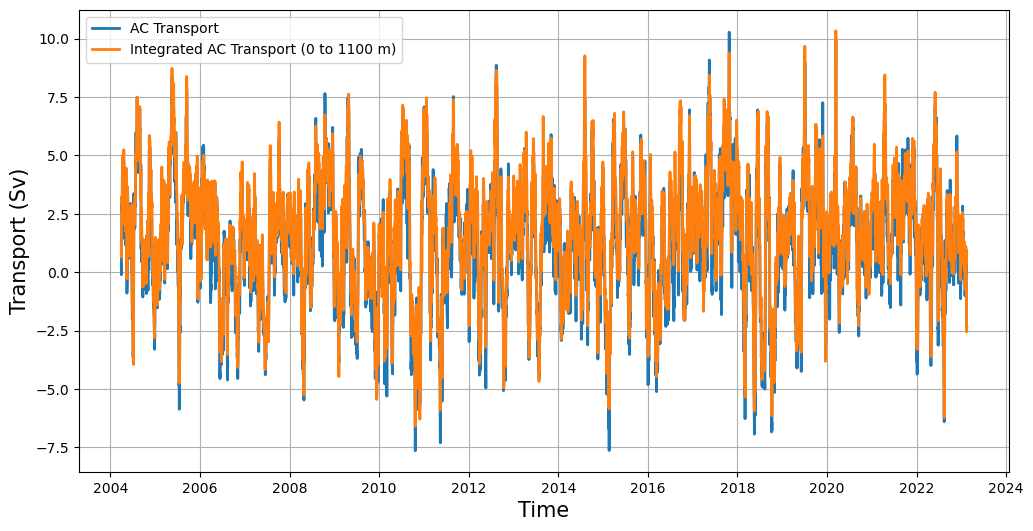

In [11]:
depth_interval = 20  #depth interval is 20 meters

# Determine the indices for depth range 0 to 1100 meters
depth_indices = np.logical_and(depth_values >= 0, depth_values <= 1100)

# Extract the transport data for the selected depth range
ac_trans_depth_range = ac_trans_depth[depth_indices, :]

# Multiply by depth interval to correct for averaging over these intervals
ac_trans_depth_range_corrected = ac_trans_depth_range * depth_interval

# Sum across depth for each time point
integrated_ac_trans_corrected = np.sum(ac_trans_depth_range_corrected, axis=0) 

# Plot and compare
plt.figure(figsize=(12, 6))
plt.plot(ac_dates, ac_trans/1e6, color='C0', linewidth=2, label='AC Transport')
plt.plot(ac_dates, integrated_ac_trans_corrected/1e6, color='C1', linewidth=2, label='Integrated AC Transport (0 to 1100 m)')

plt.xlabel('Time', fontsize=15)
plt.ylabel('Transport (Sv)', fontsize=15)
#plt.title('Comparison of Total and Integrated Transport with Depth Interval Correction', fontsize=15)
plt.legend()
plt.grid(True)
plt.show()


In [12]:
ac_series=pd.Series(integrated_ac_trans_corrected)# Need to convert to pandas to use rolling

#Filtering using Tukey: tukey(M, alpha=0.5) M=Tukey window size, true for use in filter design
alpha=0.66

#FIRST: 18-month Tukey window only one better
ac_trans_tukey_18months=ac_series.rolling(window=548,center=True).apply(lambda x:np.sum(x*windows.tukey(548,alpha))
                                                                     /np.sum(windows.tukey(548,alpha)),raw=True)


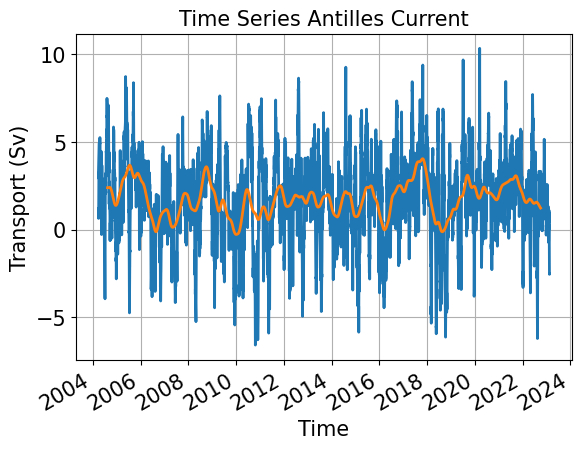

In [13]:
plt.figure()
plt.plot(ac_dates, integrated_ac_trans_corrected/1e6, color='C0', linewidth=2, label='Integrated AC Transport (0 to 1100 m)')
# Plot of 18-month Tukey filtered data
plt.plot(ac_dates,ac_trans_tukey_18months/1e6,color='C1',linewidth=2,label='Tukey filter')
plt.grid(True)
plt.ylabel('Transport (Sv)', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.title('Time Series Antilles Current', fontsize=15)
plt.gca().tick_params(axis='both', which='major', labelsize=15)
plt.gcf().autofmt_xdate()
plt.show()

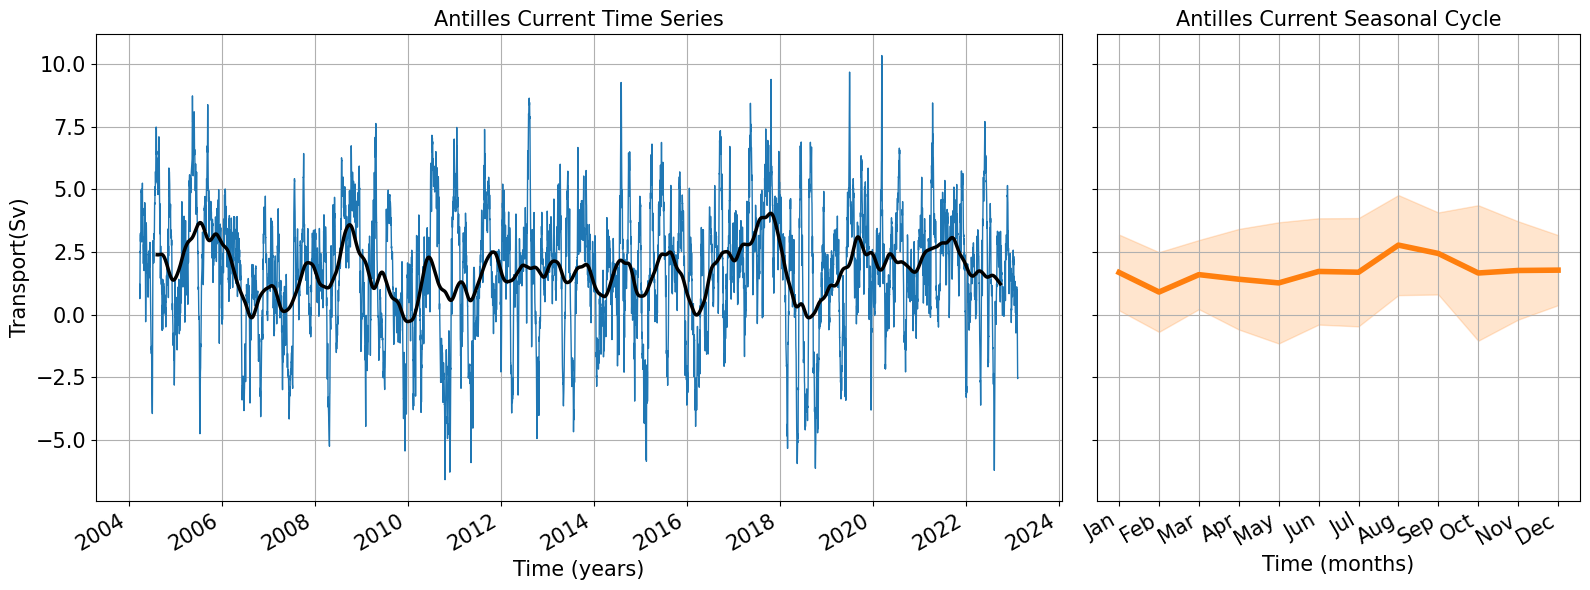

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6),sharey=True, gridspec_kw={'width_ratios': [2, 1]})
months = np.arange(1, 13)

# FIRST: Antilles Current Time Series
ax[0].plot(ac_dates,integrated_ac_trans_corrected/1e6,color='C0',linewidth=1)#C0 is blue
ax[0].plot(ac_dates,ac_trans_tukey_18months/1e6,color='k',linewidth=2.5)
ax[0].grid(True)
ax[0].set_ylabel('Transport(Sv)',fontsize=15)
ax[0].set_title('Antilles Current Time Series',fontsize=15)
ax[0].set_xlabel('Time (years)',fontsize=15)
ax[0].tick_params(axis='both',which='major',labelsize=15)

# Create a DataFrame
df = pd.DataFrame({'Date': ac_dates, 'Transport': integrated_ac_trans_corrected/1e6})
df.set_index('Date', inplace=True)  # Set the date column as the index
# Resampe to monthly data
monthly_data = df.resample('M').mean()
monthly_data['Month'] = monthly_data.index.month
seasonal_cycle = monthly_data.groupby('Month').mean()
seasonal_std = monthly_data.groupby('Month').std()

# SECOND: Antilles Current Seasonal Cycle
ax[1].plot(seasonal_cycle.index,seasonal_cycle['Transport'],color='C1',linewidth=4,label='Using Pandas')#C1 is orange
ax[1].fill_between(months,seasonal_cycle['Transport']-seasonal_std['Transport'], 
                   seasonal_cycle['Transport']+seasonal_std['Transport'],color='C1',alpha=0.2)
ax[1].grid(True)
ax[1].set_xlabel('Time (months)',fontsize=15)
ax[1].set_xticks(np.arange(1,13))
ax[1].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=15)
ax[1].set_title('Antilles Current Seasonal Cycle',fontsize=15)
fig.autofmt_xdate() #Rotate time labels
plt.tight_layout()
plt.show()

In [15]:
# Load the NetCDF file for UMO transports
file_path='/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/Sverdrup/Data/MOC_rapid/moc_transports.nc'
nc_data=Dataset(file_path,'r')

# Extract variables
umo_time=nc_data.variables['time'][:]
umo_time_units=nc_data.variables['time'].units
umo=nc_data.variables['t_umo10'][:]

# Convert time to pandas datetime
def convert_time_units(time,units):
    import calendar
    base_date=pd.to_datetime(units.split('since ')[1])
    return pd.to_datetime(base_date)+pd.to_timedelta(time,unit='days')

umo_dates=convert_time_units(umo_time,umo_time_units)

#USING PANDAS
# Create DataFrames for easier manipulation
df_umo=pd.DataFrame({'Date':umo_dates,'Transport':umo})
# Set the date column as the index
df_umo.set_index('Date',inplace=True)


In [16]:
#Compute the gyre transport, which is UMO-AC
df_ac = pd.DataFrame({'Date': ac_dates, 'Transport': integrated_ac_trans_corrected})
df_ac.set_index('Date', inplace=True)

# Check the time range for both datasets
print("UMO Time Range:")
print(df_umo.index.min(), "to", df_umo.index.max())
print("AC Time Range:")
print(df_ac.index.min(), "to", df_ac.index.max())

UMO Time Range:
2004-04-02 00:00:00 to 2023-02-11 00:00:00
AC Time Range:
2004-03-29 12:00:00 to 2023-02-14 00:00:00


In [17]:
# Trim UMO data to match the AC time range
start_date = pd.to_datetime('2004-04-07 00:00:00')#there are NaN in UMO between 2004-04-02 and 2004-04-07
#start_date = df_umo.index.min()
end_date = df_ac.index.max()
df_umo_adj = df_umo.loc[start_date:end_date]
df_ac_adj = df_ac.loc[start_date:end_date]
print(start_date)
print(df_umo_adj.index)

2004-04-07 00:00:00
DatetimeIndex(['2004-04-07 00:00:00', '2004-04-07 12:00:00',
               '2004-04-08 00:00:00', '2004-04-08 12:00:00',
               '2004-04-09 00:00:00', '2004-04-09 12:00:00',
               '2004-04-10 00:00:00', '2004-04-10 12:00:00',
               '2004-04-11 00:00:00', '2004-04-11 12:00:00',
               ...
               '2023-02-06 12:00:00', '2023-02-07 00:00:00',
               '2023-02-07 12:00:00', '2023-02-08 00:00:00',
               '2023-02-08 12:00:00', '2023-02-09 00:00:00',
               '2023-02-09 12:00:00', '2023-02-10 00:00:00',
               '2023-02-10 12:00:00', '2023-02-11 00:00:00'],
              dtype='datetime64[ns]', name='Date', length=13769, freq=None)


In [18]:
# Merge the datasets on the date index
df_merged = pd.merge(df_umo_adj, df_ac_adj, left_index=True, right_index=True, suffixes=('_umo', '_ac'))
df_merged['Gyre_Transport'] = df_merged['Transport_umo'] - df_merged['Transport_ac']/1e6

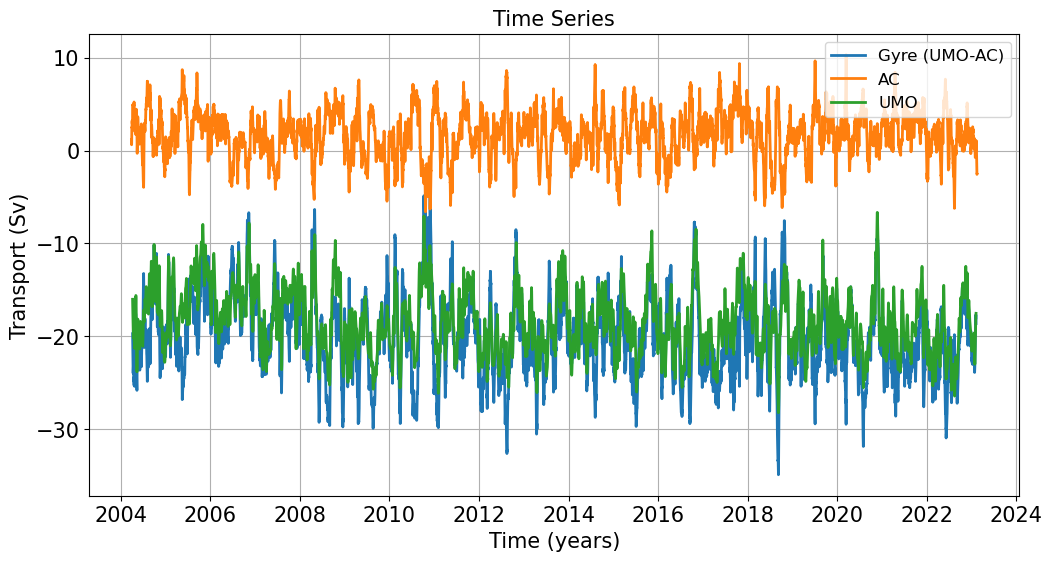

Date
2004-04-07 00:00:00   -19.725656
2004-04-07 12:00:00   -20.211480
2004-04-08 00:00:00   -20.605501
2004-04-08 12:00:00   -21.344641
2004-04-09 00:00:00   -22.118039
                         ...    
2023-02-09 00:00:00          NaN
2023-02-09 12:00:00          NaN
2023-02-10 00:00:00          NaN
2023-02-10 12:00:00          NaN
2023-02-11 00:00:00          NaN
Name: Gyre_Transport, Length: 13769, dtype: float64
Date
2004-04-07 00:00:00    3.707478e+06
2004-04-07 12:00:00    3.938140e+06
2004-04-08 00:00:00    4.019919e+06
2004-04-08 12:00:00    4.400655e+06
2004-04-09 00:00:00    4.782261e+06
                           ...     
2023-02-09 00:00:00    7.389379e+05
2023-02-09 12:00:00    3.800873e+05
2023-02-10 00:00:00   -2.772377e+04
2023-02-10 12:00:00   -4.608614e+05
2023-02-11 00:00:00   -9.397229e+05
Name: Transport_ac, Length: 13769, dtype: float64
Date
2004-04-07 00:00:00   -16.018177
2004-04-07 12:00:00   -16.273340
2004-04-08 00:00:00   -16.585582
2004-04-08 12:00:00   -16

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(df_merged.index, df_merged['Gyre_Transport'],color='C0',linewidth=2,label='Gyre (UMO-AC)')
plt.plot(ac_dates,integrated_ac_trans_corrected/1e6,color='C1',linewidth=2,label='AC')
plt.plot(umo_dates,umo,color='C2',linewidth=2,label='UMO')
plt.xlabel('Time (years)',fontsize=15)
plt.ylabel('Transport (Sv)',fontsize=15)
plt.title('Time Series',fontsize=15)
plt.legend(fontsize=12,loc='upper right')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.show()
print(df_merged['Gyre_Transport'])
print(df_merged['Transport_ac'])
print(df_merged['Transport_umo'])

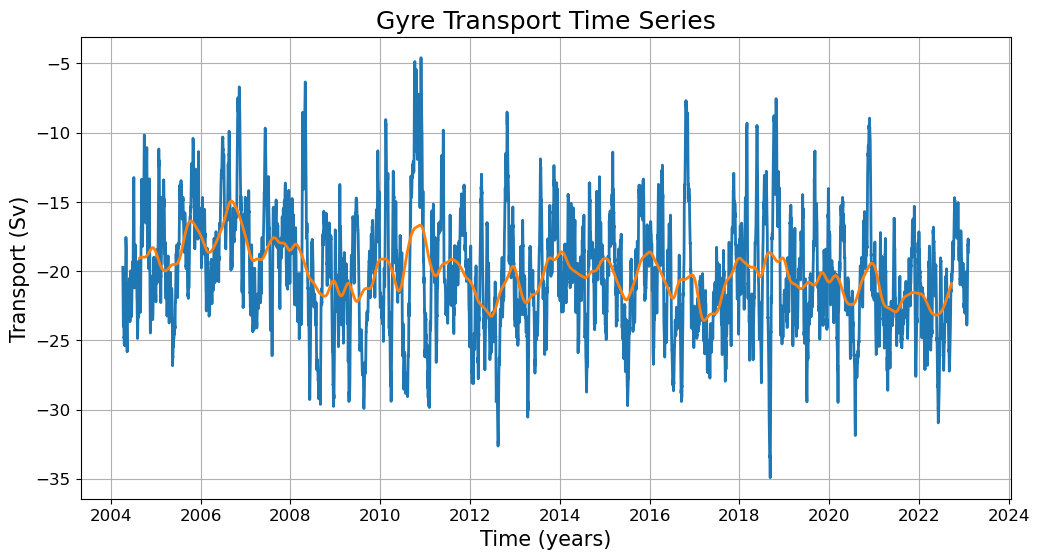

In [20]:
# Assuming df_merged['Gyre_Transport'] contains the gyre transport data
gyre_series = pd.Series(df_merged['Gyre_Transport'].values, index=df_merged.index)

# Define the alpha and Tukey window parameters
alpha = 0.66
window_size = 548  # 18 months (assuming daily data or high frequency)

# Apply the Tukey filter with a rolling window
gyre_trans_tukey_18months = gyre_series.rolling(window=window_size, center=True).apply(
    lambda x: np.sum(x * windows.tukey(window_size, alpha)) / np.sum(windows.tukey(window_size, alpha)),
    raw=True
)

# Plotting the result
plt.figure(figsize=(12, 6))

# Plot original Gyre Transport
plt.plot(gyre_series.index, gyre_series, color='C0', linewidth=2)

# Plot Tukey filtered Gyre Transport
plt.plot(gyre_series.index, gyre_trans_tukey_18months, color='C1', linewidth=2)

plt.title('Gyre Transport Time Series', fontsize=18)
plt.xlabel('Time (years)', fontsize=15)
plt.ylabel('Transport (Sv)', fontsize=15)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


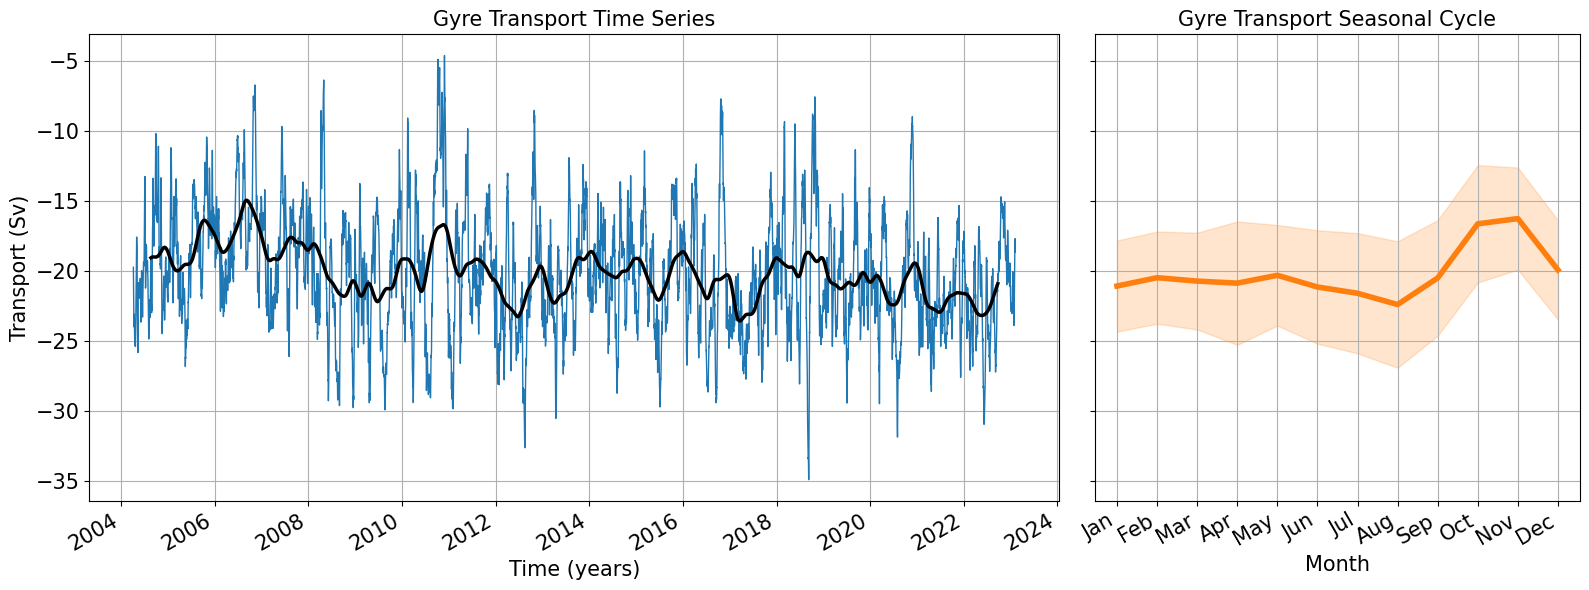

In [21]:
gyre_series = pd.Series(df_merged['Gyre_Transport'].values, index=df_merged.index)
alpha = 0.66
window_size = 548  # 18 months window size

# Apply the Tukey filter with a rolling window
gyre_trans_tukey_18months = gyre_series.rolling(window=window_size, center=True).apply(
    lambda x: np.sum(x * windows.tukey(window_size, alpha)) / np.sum(windows.tukey(window_size, alpha)),
    raw=True)

# Step 2: Compute the seasonal cycle and its standard deviation
df_merged['Month'] = df_merged.index.month
seasonal_cycle_gyre = df_merged.groupby('Month')['Gyre_Transport'].mean()
seasonal_std_gyre = df_merged.groupby('Month')['Gyre_Transport'].std()

#Plot
fig, ax = plt.subplots(1, 2, figsize=(16, 6),sharey=True, gridspec_kw={'width_ratios': [2, 1]})
# Time series with Tukey filter of Gyre
ax[0].plot(gyre_series.index, gyre_series, color='C0', linewidth=1)  # Using blue color for raw data
ax[0].plot(gyre_series.index, gyre_trans_tukey_18months, color='k', linewidth=2.5)  # Black for Tukey filter
ax[0].set_title('Gyre Transport Time Series', fontsize=15)
ax[0].set_xlabel('Time (years)', fontsize=15)
ax[0].set_ylabel('Transport (Sv)', fontsize=15)
ax[0].grid(True)
ax[0].tick_params(axis='both', which='major', labelsize=15)
fig.autofmt_xdate()  # Rotate time labels for better readability

# Seasonal cycle of gyre transport
months = np.arange(1, 13)
ax[1].plot(months, seasonal_cycle_gyre, color='C1', linewidth=4, label='Using Pandas')  # Orange for seasonal cycle
ax[1].fill_between(months, seasonal_cycle_gyre - seasonal_std_gyre, seasonal_cycle_gyre + seasonal_std_gyre, color='C1', alpha=0.2)  # Fill std dev
ax[1].set_title('Gyre Transport Seasonal Cycle', fontsize=15)
ax[1].set_xlabel('Month', fontsize=15)
ax[1].set_xticks(np.arange(1, 13))
ax[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=15)
ax[1].grid(True)
ax[1].tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()

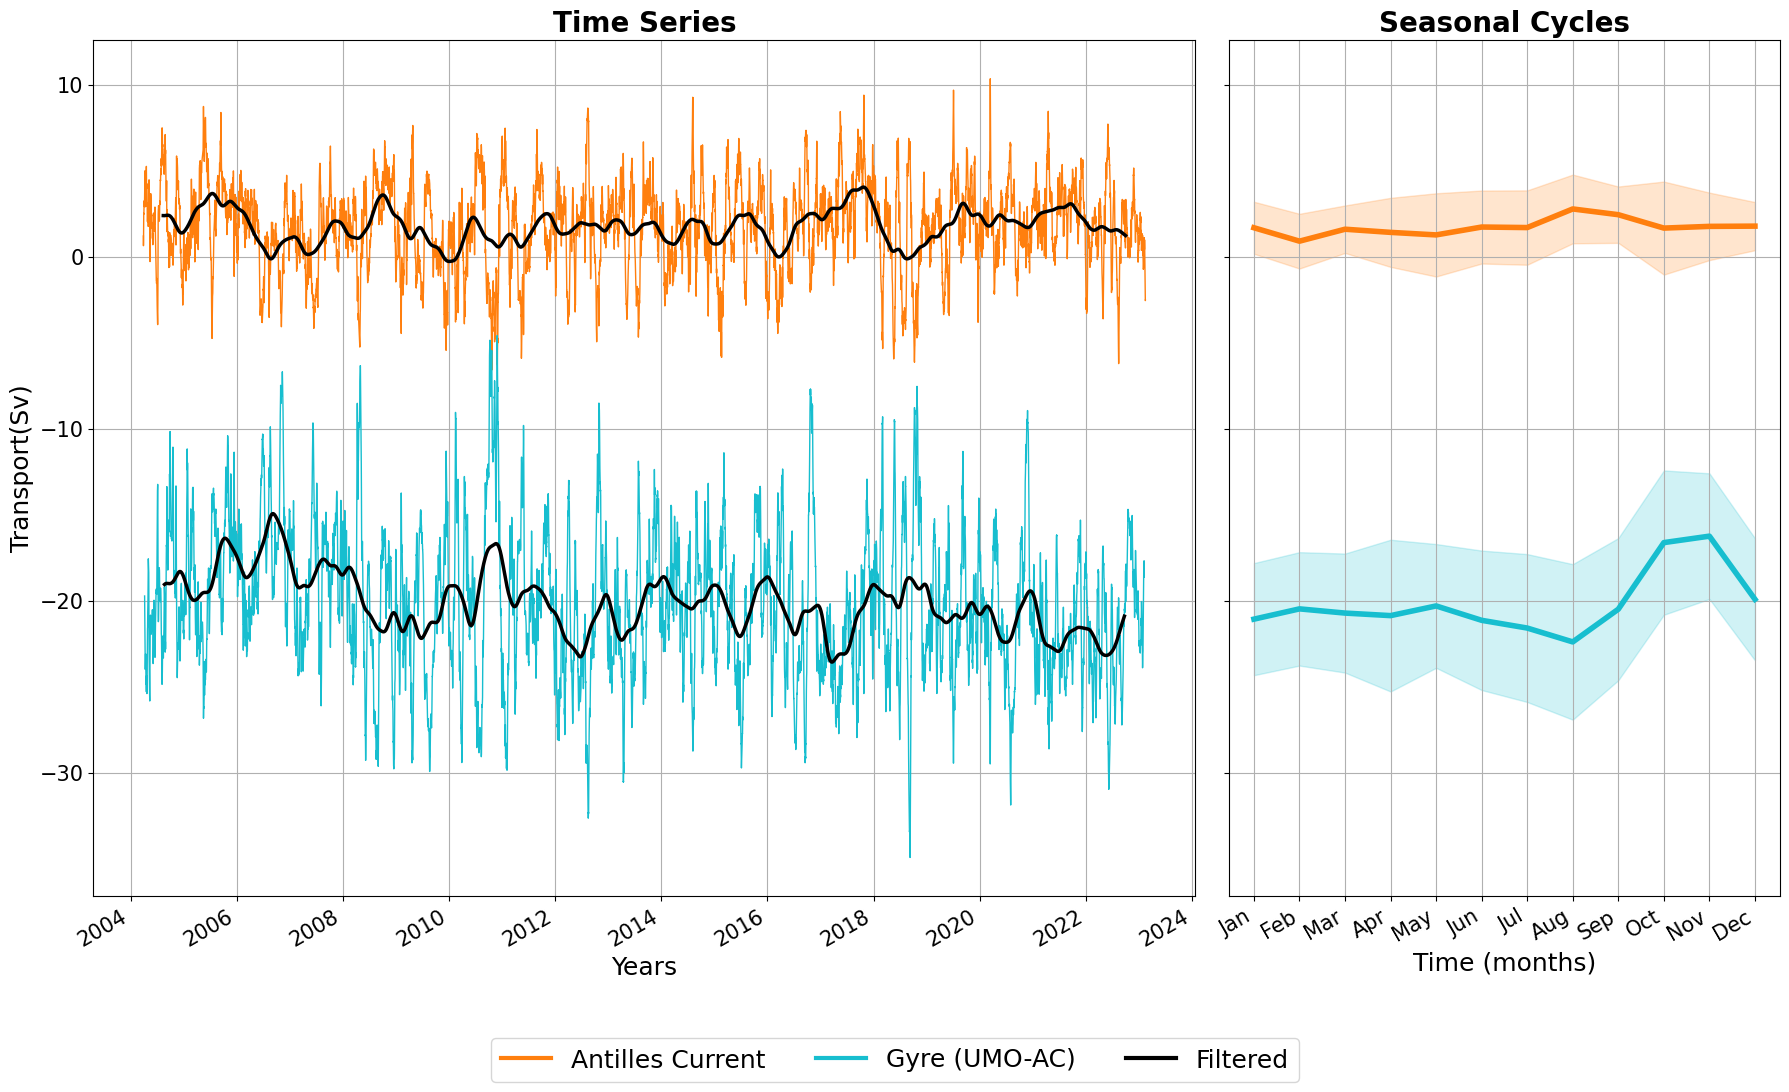

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(18, 10),sharey=True, gridspec_kw={'width_ratios': [2, 1]})
months = np.arange(1, 13)

# FIRST: Antilles Current Time Series
ax[0].plot(ac_dates,integrated_ac_trans_corrected/1e6,color='C1',linewidth=1,label='AC')#C0 is blue
ax[0].plot(ac_dates,ac_trans_tukey_18months/1e6,color='k',linewidth=2.5,label='Gyre (UMO-AC)')
ax[0].plot(gyre_series.index, gyre_series, color='C9', linewidth=1)  # Using blue color for raw data
ax[0].plot(gyre_series.index, gyre_trans_tukey_18months, color='k', linewidth=2.5)  # Black for Tukey filter
ax[0].grid(True)
ax[0].set_ylabel('Transport(Sv)',fontsize=18)
ax[0].set_title('Time Series', fontsize=20,fontweight='bold')
ax[0].set_xlabel('Years',fontsize=18)
ax[0].tick_params(axis='both',which='major',labelsize=15)

# SECOND: Antilles Current Seasonal Cycle
ax[1].plot(seasonal_cycle.index,seasonal_cycle['Transport'],color='C1',linewidth=4)
ax[1].fill_between(months,seasonal_cycle['Transport']-seasonal_std['Transport'], 
                   seasonal_cycle['Transport']+seasonal_std['Transport'],color='C1',alpha=0.2)
ax[1].plot(months, seasonal_cycle_gyre, color='C9', linewidth=4)
ax[1].fill_between(months, seasonal_cycle_gyre - seasonal_std_gyre, seasonal_cycle_gyre + seasonal_std_gyre, color='C9', alpha=0.2)  
ax[1].grid(True)
ax[1].set_xlabel('Time (months)',fontsize=18)
ax[1].set_xticks(np.arange(1,13))
ax[1].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=15)
ax[1].set_title('Seasonal Cycles', fontsize=20,fontweight='bold')
fig.autofmt_xdate() #Rotate time labels
plt.tight_layout()
legend_elements = [Line2D([0],[0],color='C1',lw=3,label='Antilles Current'),
                   Line2D([0],[0],color='C9',lw=3,label='Gyre (UMO-AC)'),
                   Line2D([0],[0],color='k',lw=3,label='Filtered')]
fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=18, bbox_to_anchor=(0.5, -0.1))

plt.show()

In [23]:
# Create a new xarray.Dataset with the necessary variables for new plots
ds = xr.Dataset({
    'ac_dates': ac_dates,
    'integrated_ac_trans_corrected': integrated_ac_trans_corrected,
    'ac_trans_tukey_18months': ac_trans_tukey_18months,
    'gyre_series.index':gyre_series.index,
    'gyre_series':gyre_series,
    'gyre_trans_tukey_18months':gyre_trans_tukey_18months
})

# Save the dataset to a NetCDF file
#ds.to_netcdf('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/Sverdrup/Data/Winds/ac_gyre_trans_2023.nc')

In [24]:
nan_moc_times = gyre_series[gyre_series.isna()].index
nan_moc_count = gyre_series.isna().sum()
print(f"NaN values in df_moc['Transport']: {nan_moc_count}")
print(f"Timestamps with NaN values in df_moc: {nan_moc_times}")

NaN values in df_moc['Transport']: 10
Timestamps with NaN values in df_moc: DatetimeIndex(['2023-02-06 12:00:00', '2023-02-07 00:00:00',
               '2023-02-07 12:00:00', '2023-02-08 00:00:00',
               '2023-02-08 12:00:00', '2023-02-09 00:00:00',
               '2023-02-09 12:00:00', '2023-02-10 00:00:00',
               '2023-02-10 12:00:00', '2023-02-11 00:00:00'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [25]:
ac_trans = xr.open_dataset('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/Sverdrup/Data/Winds/ac_gyre_trans_2023.nc')
# Antilles Current dataset
ac_dates=ac_trans['ac_dates']
ac_series=ac_trans['integrated_ac_trans_corrected']
# Associate ac_series with ac_dates and create a new DataArray
ac_series_da = xr.DataArray(ac_series.values, coords=[ac_dates], dims=["time"])
# Convert AC daily data to monthly averages
ac_monthly_series = ac_series_da.resample(time='M').mean()
# Convert the time index to pandas DatetimeIndex, shift by 14 days, and convert back
new_time = ac_monthly_series['time'].to_index() + pd.DateOffset(days=15)
ac_monthly_series['time'] = new_time

fc_trans = xr.open_dataset('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/Sverdrup/Data/Winds/fc_transports.nc')
# Assuming fc_trans is already defined and contains 'fc_dates' and 'integrated_fc_trans_corrected'
fc_dates = fc_trans['fc_dates']
fc_series = fc_trans['integrated_fc_trans_corrected']
fc_series_array = xr.DataArray(data=fc_series, coords=[pd.to_datetime(fc_dates)], dims=["time"])

first_date=ac_series_da.time[~ac_series_da.isnull()].min()
last_date=ac_series_da.time[~ac_series_da.isnull()].max()

fc_series_cropped = fc_series_array.sel(time=slice(first_date, last_date))

# Convert fc_dates to pandas DatetimeIndex
fc_data = pd.to_datetime(fc_dates)
# Adjust dates to the 15th of each month
def adjust_to_fifteenth(date):
    if date.day < 15:
        return date.replace(day=15)
    else:
        return date + pd.DateOffset(months=1, days=-date.day + 15)
fc_data_15th = fc_data.to_series().apply(adjust_to_fifteenth)
fc_monthly_series = xr.DataArray(data=fc_series, coords=[pd.to_datetime(fc_data_15th)], dims=["time"])

# Apply 3-month moving average filter for the converted xarray DataArrays
fc_3m = fc_monthly_series.rolling(time=3, center=True).mean()
ac_3m=ac_monthly_series.rolling(time=3,center=True).mean()
# Apply 1-year moving average filter for the converted xarray DataArrays
fc_1y = fc_3m.rolling(time=12, center=True).mean()
ac_1y=ac_3m.rolling(time=12,center=True).mean()

# Get the indices of the first and last valid (non-NaN) entries for the AC time series
first_valid_index = ac_1y.time[~ac_1y.isnull()].min()
last_valid_index = ac_1y.time[~ac_1y.isnull()].max()

# Crop FC data to match the time period of AC data
fc_monthly_series_cropped = fc_1y.sel(time=slice(first_valid_index, last_valid_index))
ac_monthly_series_cropped = ac_1y.sel(time=slice(first_valid_index, last_valid_index))

# Using Pandas
# Create a DataFrame for easier manipulation
df=pd.DataFrame({'Date':fc_series_cropped.time,'Transport':fc_series_cropped})
df.set_index('Date',inplace=True)# Set the date column as the index

# Seasonal cycle and std of the Florida Current
monthly_data2=df.resample('M').mean()
seasonal_cycle2=monthly_data2.groupby(df.index.month).mean()
seasonal_std2=monthly_data2.groupby(df.index.month).std()

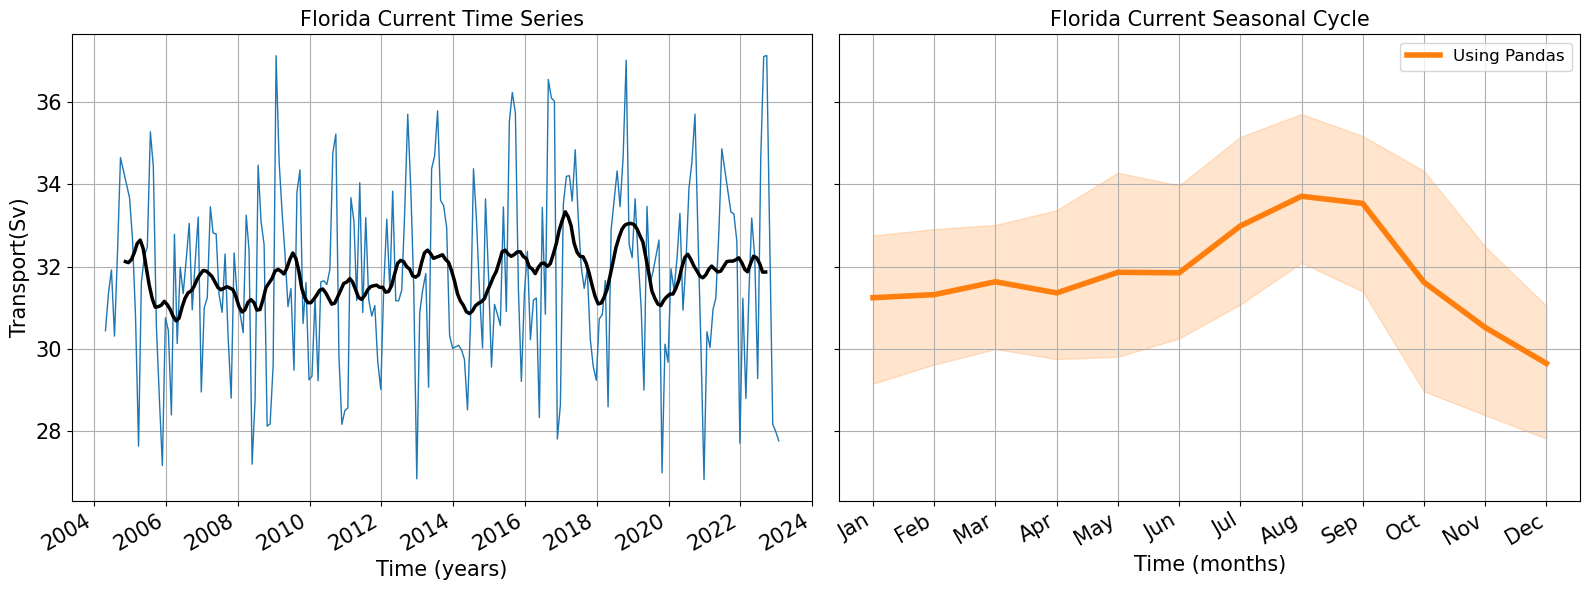

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
months = np.arange(1, 13)

# FIRST: Florida Current Time Series
ax[0].plot(fc_series_cropped.time,fc_series_cropped,color='C0',linewidth=1)#C0 is blue
ax[0].plot(fc_monthly_series_cropped.time,fc_monthly_series_cropped,color='k',linewidth=2.5)
ax[0].grid(True)
ax[0].set_ylabel('Transport(Sv)',fontsize=15)
ax[0].set_title('Florida Current Time Series',fontsize=15)
ax[0].set_xlabel('Time (years)',fontsize=15)
ax[0].tick_params(axis='both',which='major',labelsize=15)

# SECOND: Florida Current Seasonal Cycle
ax[1].plot(seasonal_cycle2.index,seasonal_cycle2['Transport'],color='C1',linewidth=4,label='Using Pandas')#C1 is orange
ax[1].fill_between(months,seasonal_cycle2['Transport']-seasonal_std2['Transport'], 
                   seasonal_cycle2['Transport']+seasonal_std['Transport'],color='C1',alpha=0.2)
#ax[1].plot(np.arange(1,13),seasonal_cycle_xarray,color='k',linestyle='--',linewidth=1.5,label='Using Xarray')  # C0 is blue
#ax[1].fill_between(np.arange(1,13),seasonal_cycle_xarray-seasonal_std_xarray,
                   #seasonal_cycle_xarray+seasonal_std_xarray,color='k',alpha=0.1)
ax[1].grid(True)
ax[1].set_xlabel('Time (months)',fontsize=15)
ax[1].set_xticks(np.arange(1,13))
ax[1].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=15)
ax[1].set_title('Florida Current Seasonal Cycle',fontsize=15)
ax[1].legend(loc='upper right',fontsize=12)

fig.autofmt_xdate() #Rotate time labels
plt.tight_layout()
plt.show()

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(18, 10),sharey=True, gridspec_kw={'width_ratios': [2, 1]})
months = np.arange(1, 13)

# FIRST: Antilles Current Time Series
ax[0].plot(ac_dates,integrated_ac_trans_corrected/1e6,color='C1',linewidth=1,label='AC')#C0 is blue
ax[0].plot(ac_dates,ac_trans_tukey_18months/1e6,color='k',linewidth=2.5,label='Gyre (UMO-AC)')
ax[0].plot(gyre_series.index, gyre_series, color='C9', linewidth=1)  # Using blue color for raw data
ax[0].plot(gyre_series.index, gyre_trans_tukey_18months, color='k', linewidth=2.5)  # Black for Tukey filter
#ax[0].plot(fc_series_cropped.time,fc_series_cropped,color='C6',linewidth=1,label='FC')#C0 is blue
#ax[0].plot(fc_monthly_series_cropped.time,fc_monthly_series_cropped,color='k',linewidth=2.5)
ax[0].grid(True)
ax[0].set_ylabel('Transport(Sv)',fontsize=18)
#ax[0].set_title('Time Series', fontsize=20,fontweight='bold')
ax[0].set_xlabel('Years',fontsize=18)
ax[0].tick_params(axis='both',which='major',labelsize=15)

# SECOND: Antilles Current Seasonal Cycle
ax[1].plot(seasonal_cycle.index,seasonal_cycle['Transport'],color='C1',linewidth=4)
ax[1].fill_between(months,seasonal_cycle['Transport']-seasonal_std['Transport'], 
                   seasonal_cycle['Transport']+seasonal_std['Transport'],color='C1',alpha=0.2)
ax[1].plot(months, seasonal_cycle_gyre, color='C9', linewidth=4)
ax[1].fill_between(months, seasonal_cycle_gyre - seasonal_std_gyre, seasonal_cycle_gyre + seasonal_std_gyre, color='C9', alpha=0.2)  
#ax[1].plot(seasonal_cycle2.index,seasonal_cycle2['Transport'],color='C6',linewidth=4)#C1 is orange
#ax[1].fill_between(months,seasonal_cycle2['Transport']-seasonal_std2['Transport'], 
                   seasonal_cycle2['Transport']+seasonal_std2['Transport'],color='C6',alpha=0.2)
ax[1].grid(True)
ax[1].set_xlabel('Months',fontsize=18)
ax[1].set_xticks(np.arange(1,13))
ax[1].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=15)
#ax[1].set_title('Seasonal Cycles', fontsize=20,fontweight='bold')
fig.autofmt_xdate() #Rotate time labels
plt.tight_layout()
legend_elements = [Line2D([0],[0],color='C0',lw=3,label='Florida Straits'),
                   Line2D([0],[0],color='C3',lw=3,label='AMOC'),
                   Line2D([0],[0],color='C2',lw=3,label='Ekman'),
                   Line2D([0],[0],color='C4',lw=3,label='UMO'),
                   Line2D([0],[0],color='C6',lw=3,label='Florida Current'),
                   Line2D([0],[0],color='C1',lw=3,label='Antilles Current'),
                   Line2D([0],[0],color='C9',lw=3,label='Gyre (UMO-AC)'),
                   Line2D([0],[0],color='k',lw=3,label='Filtered')]
fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=18, bbox_to_anchor=(0.5, -0.1))

plt.show()

IndentationError: unexpected indent (3044204490.py, line 25)

In [28]:
from scipy.signal import windows
ac_series = pd.Series(integrated_ac_trans_corrected / 1e6)
fc_series=pd.Series(fc_series_cropped)

# Apply the 3-month boxcar filter (90-point rolling mean)
ac_3months_boxcar = ac_series.rolling(window=90, center=True).mean()
gyre_3months_boxcar = gyre_series.rolling(window=90, center=True).mean()
fc_3months_boxcar = fc_series.rolling(window=90, center=True).mean()

# Apply the 1-year boxcar filter (365-point rolling mean) on the 3-month filtered data
ac_1year_boxcar = ac_3months_boxcar.rolling(window=365, center=True).mean()
gyre_1year_boxcar = gyre_3months_boxcar.rolling(window=365, center=True).mean()
fc_1year_boxcar = fc_3months_boxcar.rolling(window=365, center=True).mean()

# SAME FOR FILTERED DATA (Create DataFrames for easier manipulation)
df_ac_boxcar=pd.DataFrame({'Date':ac_dates,'Filtered_Transport':ac_1year_boxcar})
df_gyre_boxcar=pd.DataFrame({'Date':gyre_series.index,'Filtered_Transport':gyre_1year_boxcar})
df_fc_boxcar=pd.DataFrame({'Date':fc_series_cropped.time,'Filtered_Transport':fc_1year_boxcar})


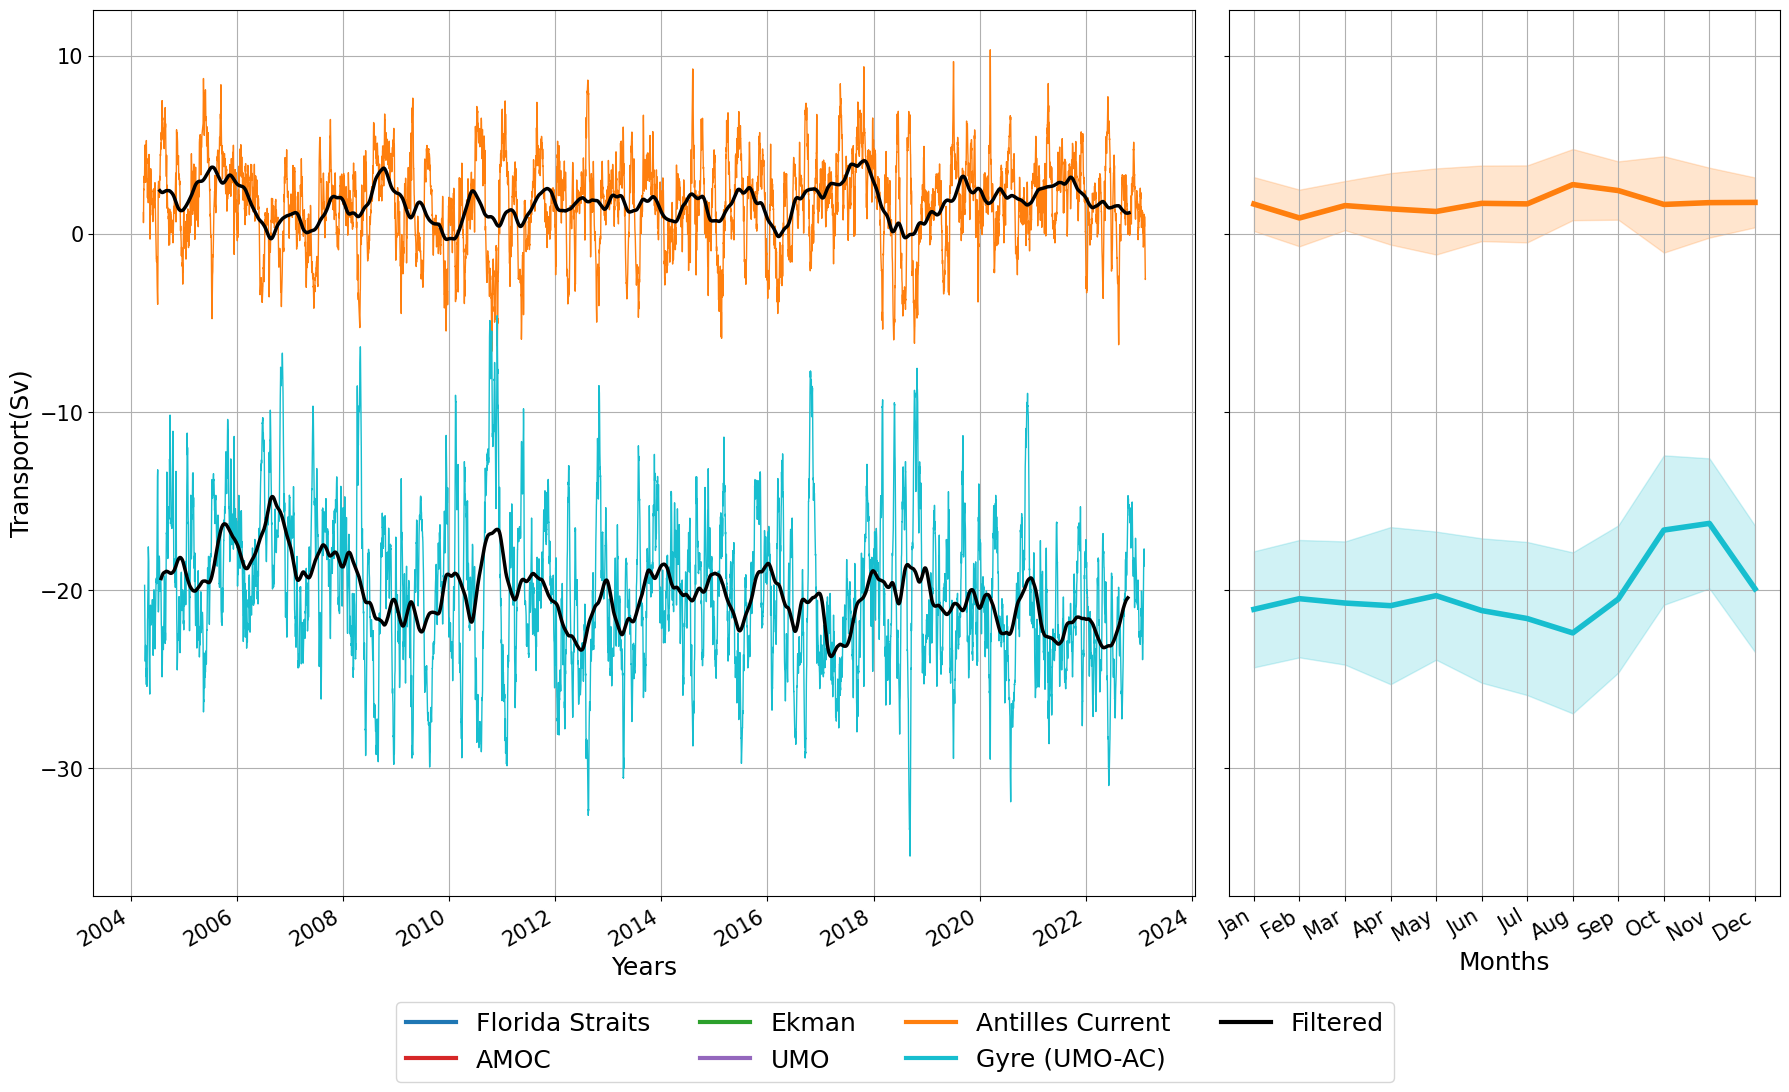

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(18, 10),sharey=True, gridspec_kw={'width_ratios': [2, 1]})
months = np.arange(1, 13)
# FIRST: Antilles Current Time Series
ax[0].plot(ac_dates,integrated_ac_trans_corrected/1e6,color='C1',linewidth=1,label='AC')#C0 is blue
ax[0].plot(ac_dates,ac_1year_boxcar,color='k',linewidth=2.5,label='Gyre (UMO-AC)')
ax[0].plot(gyre_series.index, gyre_series, color='C9', linewidth=1)  # Using blue color for raw data
ax[0].plot(gyre_series.index, gyre_1year_boxcar, color='k', linewidth=2.5)  # Black for Tukey filter
#ax[0].plot(fc_series_cropped.time,fc_series_cropped,color='C6',linewidth=1,label='FC')#C0 is blue
#ax[0].plot(fc_series_cropped.time,fc_1year_boxcar,color='k',linewidth=2.5)
ax[0].grid(True)
ax[0].set_ylabel('Transport(Sv)',fontsize=18)
#ax[0].set_title('Time Series', fontsize=20,fontweight='bold')
ax[0].set_xlabel('Years',fontsize=18)
ax[0].tick_params(axis='both',which='major',labelsize=15)

# SECOND: Antilles Current Seasonal Cycle
ax[1].plot(seasonal_cycle.index,seasonal_cycle['Transport'],color='C1',linewidth=4)
ax[1].fill_between(months,seasonal_cycle['Transport']-seasonal_std['Transport'], 
                   seasonal_cycle['Transport']+seasonal_std['Transport'],color='C1',alpha=0.2)
ax[1].plot(months, seasonal_cycle_gyre, color='C9', linewidth=4)
ax[1].fill_between(months, seasonal_cycle_gyre - seasonal_std_gyre, seasonal_cycle_gyre + seasonal_std_gyre, color='C9', alpha=0.2)  
#ax[1].plot(seasonal_cycle2.index,seasonal_cycle2['Transport'],color='C6',linewidth=4)#C1 is orange
#ax[1].fill_between(months,seasonal_cycle2['Transport']-seasonal_std2['Transport'], 
                   #seasonal_cycle2['Transport']+seasonal_std2['Transport'],color='C6',alpha=0.2)
ax[1].grid(True)
ax[1].set_xlabel('Months',fontsize=18)
ax[1].set_xticks(np.arange(1,13))
ax[1].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=15)
#ax[1].set_title('Seasonal Cycles', fontsize=20,fontweight='bold')
fig.autofmt_xdate() #Rotate time labels
plt.tight_layout()
legend_elements = [Line2D([0],[0],color='C0',lw=3,label='Florida Straits'),
                   Line2D([0],[0],color='C3',lw=3,label='AMOC'),
                   Line2D([0],[0],color='C2',lw=3,label='Ekman'),
                   Line2D([0],[0],color='C4',lw=3,label='UMO'),
                  # Line2D([0],[0],color='C6',lw=3,label='Florida Current'),
                   Line2D([0],[0],color='C1',lw=3,label='Antilles Current'),
                   Line2D([0],[0],color='C9',lw=3,label='Gyre (UMO-AC)'),
                   Line2D([0],[0],color='k',lw=3,label='Filtered')]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=18, bbox_to_anchor=(0.5, -0.1))

plt.show()

In [30]:
import numpy as np
import pandas as pd

def trendline(index, data, order=1):
    # Convert datetime index to numeric (e.g., ordinal format)
    if np.issubdtype(index.dtype, np.datetime64):
        index = pd.to_datetime(index).map(pd.Timestamp.toordinal)
    
    # Fit a polynomial of the specified order to the data
    coeffs = np.polyfit(index, data, order)
    # Extract the slope for a linear trend or return coefficients for higher orders
    slope = coeffs[-2] if order == 1 else coeffs
    return slope

# Example usage (assuming gyre_series is a Pandas Series with a datetime index)
resultant = trendline(gyre_series.index, gyre_series.values)
print(resultant)



nan


In [31]:
import numpy as np
import pandas as pd

def trendline(index, data, order=1):
    # Ensure no NaN values in data or index
    if np.isnan(data).any() or np.isnan(index).any():
        print("Data or index contains NaN values. Dropping NaNs.")
        # Drop NaNs if they exist
        valid_data = pd.DataFrame({'index': index, 'data': data}).dropna()
        index, data = valid_data['index'].values, valid_data['data'].values

    # Convert datetime index to numeric (e.g., ordinal format) if needed
    if np.issubdtype(index.dtype, np.datetime64):
        index = pd.to_datetime(index).map(pd.Timestamp.toordinal)
    
    # Fit a polynomial of the specified order to the data
    coeffs = np.polyfit(index, data, order)
    # Extract the slope (for a linear trend, it's the first coefficient)
    slope = coeffs[-2] if order == 1 else coeffs
    return slope

# Example usage (assuming gyre_series is a Pandas Series with a datetime index)
resultant = trendline(gyre_series.index, gyre_series.values)
print(resultant)


Data or index contains NaN values. Dropping NaNs.
-0.00043415316737471804


The equation of the trendline is: y = -0.000434x + 299.001694
Slope: -0.00043415316737471804
Standard Error of the Slope: 0.03577712834640638
Coefficients: [-4.34153167e-04  2.99001694e+02]
Trend values: [-18.65862691 -18.65862691 -18.65906107 ... -21.6447324  -21.6447324
 -21.64516655]
Slope Filtered: -0.000496861554163563
Standard Error of the Slope Filtered: 0.012493832204342274
Coefficients Filtered: [-4.96861554e-04  3.45109293e+02]
Trend values Filtered: [-18.48952108 -18.49001794 -18.49001794 ... -21.79464414 -21.79464414
 -21.795141  ]


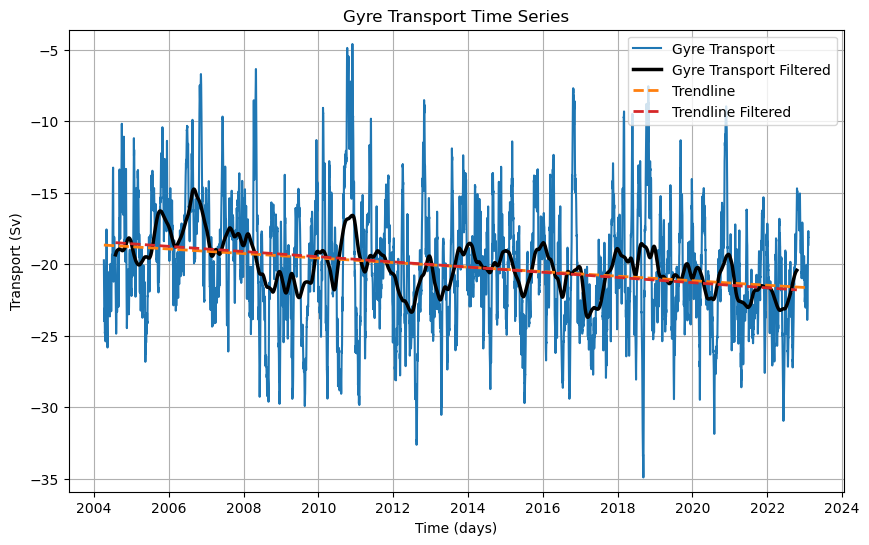

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Check for NaN values in gyre_series
if gyre_series.isna().any():
    # Drop NaN values from the series
    gyre_series_cleaned = gyre_series.dropna()
    gyre_1year_boxcar_cleaned=gyre_1year_boxcar.dropna()
    
else:
    gyre_series_cleaned = gyre_series
    gyre_1year_boxcar_cleaned=gyre_1year_boxcar

# Convert datetime index to numeric for polyfit
index_numeric = pd.to_datetime(gyre_series_cleaned.index).map(pd.Timestamp.toordinal)
index_numeric_fil=pd.to_datetime(gyre_1year_boxcar_cleaned.index).map(pd.Timestamp.toordinal)

# Compute the trendline coefficients
coeffs = np.polyfit(index_numeric, gyre_series_cleaned.values, 1)
coeffs_fil=np.polyfit(index_numeric_fil,gyre_1year_boxcar_cleaned.values,1)

# Generate trendline values using the coefficients
trend = np.polyval(coeffs, index_numeric)
trend_fil=np.polyval(coeffs_fil,index_numeric_fil)

# Calculate residuals
residuals = gyre_series_cleaned.values - trend
residuals_fil=gyre_1year_boxcar_cleaned.values-trend_fil

# Calculate standard deviation of the residuals
std_residuals = np.std(residuals)
std_residuals_fil=np.std(residuals_fil)

# The slope is the first coefficient from polyfit and the second is the intercept
slope = coeffs[0]
intercept = coeffs[1]

slope_fil=coeffs_fil[0]
intercep_fil=coeffs_fil[1]

# Equation of the trendline
print(f"The equation of the trendline is: y = {slope:.6f}x + {intercept:.6f}")
#print(f'The equation of the trendline filtered is: y = {slope_fil:.6f}x + {intercept_fil:.6f}")
# Calculate the standard error of the slope
n = len(gyre_series_cleaned)  # number of observations
slope_std_error = std_residuals / np.sqrt(n)  # Standard error of the slope

n_fil=len(gyre_1year_boxcar_cleaned)
slope_std_error_fil = std_residuals_fil/np.sqrt(n_fil)
      
# Print the results
print("Slope:", slope)
print("Standard Error of the Slope:", slope_std_error)
print("Coefficients:", coeffs)
print("Trend values:", trend)
      
print("Slope Filtered:", slope_fil)
print("Standard Error of the Slope Filtered:", slope_std_error_fil)
print("Coefficients Filtered:", coeffs_fil)
print("Trend values Filtered:", trend_fil)

# Plot original data and trendline
plt.figure(figsize=(10, 6))
plt.plot(gyre_series_cleaned.index, gyre_series_cleaned.values, label="Gyre Transport", color='C0')
plt.plot(gyre_series.index, gyre_1year_boxcar, color='k', linewidth=2.5,label='Gyre Transport Filtered')
plt.plot(gyre_series_cleaned.index, trend, color="C1", linestyle="--", label="Trendline", linewidth=2)
plt.plot(gyre_1year_boxcar_cleaned.index, trend_fil, color="C3", linestyle="--", label="Trendline Filtered", linewidth=2)
plt.xlabel("Time (days)")
plt.ylabel("Transport (Sv)")
plt.title("Gyre Transport Time Series")
plt.ylim(gyre_series_cleaned.values.min() - 1, gyre_series_cleaned.values.max() + 1)  # Adjust y-axis limits
plt.legend(loc='upper right')
plt.grid()
plt.show()
